# Combining it all

Here we will combine the approaches of all the past inversions. Here our the main steps we will follow:

1) create a true topography and synthetic observed gravity
2) create a starting model from the points of known topography (`constraints`) 
3) calculate a starting misfit
4) perform a damping parameter cross validation to determine the optimal damping value
5) use this damping value to perform a cross validation to find the optimal density and reference level values
6) create the weighting grid to help the inversion adhere to the constraints
7) perform a full final inversion constrained by the `weighting grid`, using the optimal damping, density, and reference level values. 


## Import packages

In [47]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import itertools
import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from antarctic_plots import utils as ap_utils

from invert4geom import cross_validation, inversion, plotting, synthetic, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Create synthetic topography and observed gravity data

### True topography

In [48]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

## 2) Create starting topography from constraints

Sample the starting topography at 10 random locations and regrid with those sampled values. This sumulates only knowing the depth to this topography at 10 boreholes.

In [50]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
grd = vd.Spline()
coords = (constraint_points.easting, constraint_points.northing)
grd.fit(coords, constraint_points.upward)
starting_topography = grd.grid(
    region=region,
    spacing=spacing,
).scalars

# re-sample the starting topography at the constraint points to see how the gridded did
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_topography)
print(f"RMSE at the constraints between the starting and true topography: {rmse:.2f} m")

RMSE at the constraints between the starting and true topography: 0.14 m


returning original grid
returning original grid


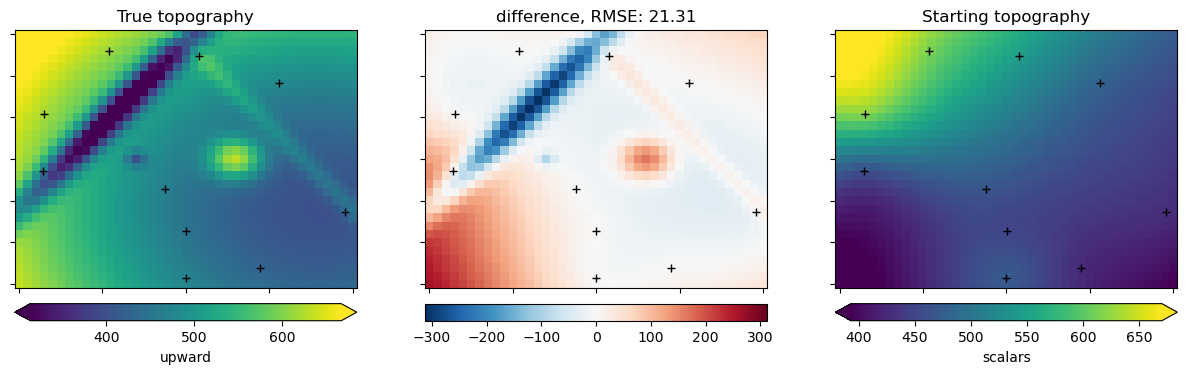

In [51]:
_ = ap_utils.grd_compare(
    true_topography,
    starting_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

### Prism layer

In [52]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()
print(f"zref: {zref:.2f} m")

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

zref: 492.27 m


### Forward gravity of prism layer

In [53]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


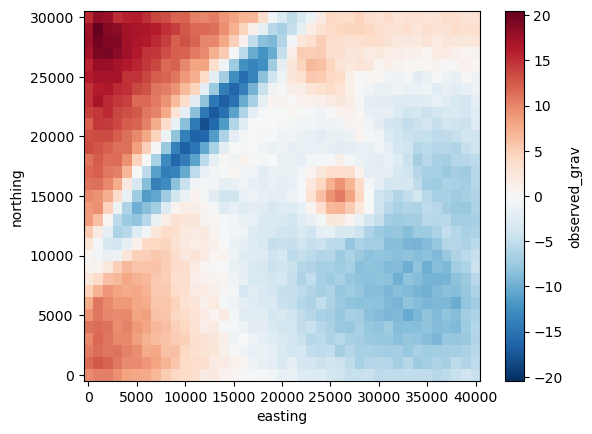

In [54]:
# contaminate gravity with 1 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav.plot()

## 3) Calculate starting gravity misfit 
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

We don't know the optimal values for the density contrast or the reference level, so we will make a guess at appropiate values for the starting model.

In [55]:
# the true zref value is 492 m
zref = 400

# the true density contrast is 2669 kg/m3
density_contrast = 2500

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,1000.0,9.534643,9.617711,-1.126569,10.744280,0,10.744280
1,0.0,1000.0,1000.0,10.422834,10.376985,-1.254163,11.631147,0,11.631147
2,0.0,2000.0,1000.0,9.949973,10.290387,-1.112652,11.403039,0,11.403039
3,0.0,3000.0,1000.0,9.269279,9.341932,-0.890808,10.232740,0,10.232740
4,0.0,4000.0,1000.0,8.532160,8.284528,-0.618830,8.903358,0,8.903358
...,...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716,2.794223,6.381211,-3.586988,0,-3.586988
1267,30000.0,37000.0,1000.0,3.330307,3.683446,6.064933,-2.381488,0,-2.381488
1268,30000.0,38000.0,1000.0,3.335438,3.501867,5.720061,-2.218195,0,-2.218195
1269,30000.0,39000.0,1000.0,3.300721,2.848068,5.270974,-2.422906,0,-2.422906


## 4) Damping parameter cross validation

In [56]:
# resample to half spacing
grav_df_resampled = cross_validation.resample_with_test_points(spacing, grav_df, region)
grav_df_resampled

,northing,easting,test,upward,grav,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,False,1000.0,9.534643,9.617711,-1.126569,10.744280,0,10.744280
1,0.0,500.0,True,1000.0,10.063805,10.050215,-1.207185,11.257400,0,11.257400
2,0.0,1000.0,False,1000.0,10.422834,10.376985,-1.254163,11.631147,0,11.631147
3,0.0,1500.0,True,1000.0,10.284459,10.440419,-1.205247,11.645666,0,11.645666
4,0.0,2000.0,False,1000.0,9.949973,10.290387,-1.112652,11.403039,0,11.403039
...,...,...,...,...,...,...,...,...,...,...
4936,30000.0,38000.0,False,1000.0,3.335438,3.501867,5.720061,-2.218194,0,-2.218194
4937,30000.0,38500.0,True,1000.0,3.346051,3.145170,5.538997,-2.393827,0,-2.393827
4938,30000.0,39000.0,False,1000.0,3.300721,2.848068,5.270974,-2.422906,0,-2.422906
4939,30000.0,39500.0,True,1000.0,3.104991,2.936345,4.787667,-1.851323,0,-1.851323


Parameter values:   0%|          | 0/12 [00:00<?, ?it/s]

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


INFO:root:Parameter value: 0.001 -> Score: 6.732047831677581
INFO:root:Parameter value: 0.001873817422860383 -> Score: 1.8837831771800073
INFO:root:Parameter value: 0.003511191734215131 -> Score: 0.7978617321533572
INFO:root:Parameter value: 0.006579332246575682 -> Score: 0.20486238276499408
INFO:root:Parameter value: 0.012328467394420659 -> Score: 0.1445807061513888
INFO:root:Parameter value: 0.02310129700083159 -> Score: 0.13652106424636976
INFO:root:Parameter value: 0.04328761281083057 -> Score: 0.15907282405356327
INFO:root:Parameter value: 0.08111308307896868 -> Score: 0.1659793736262551
INFO:root:Parameter value: 0.1519911082952933 -> Score: 0.27262899597641055
INFO:root:Parameter value: 0.2848035868435799 -> Score: 1.2405563485753364
INFO:root:Parameter value: 0.5336699231206307 -> Score: 5.323488898748665
INFO:root:Parameter value: 1.0 -> Score: 11.0050069948716
INFO:root:Best score of 0.13652106424636976 with parameter value=0.02310129700083159


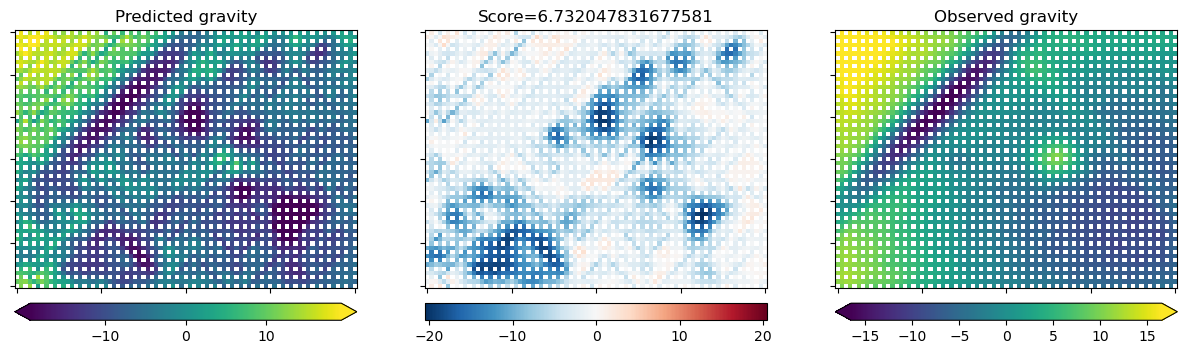

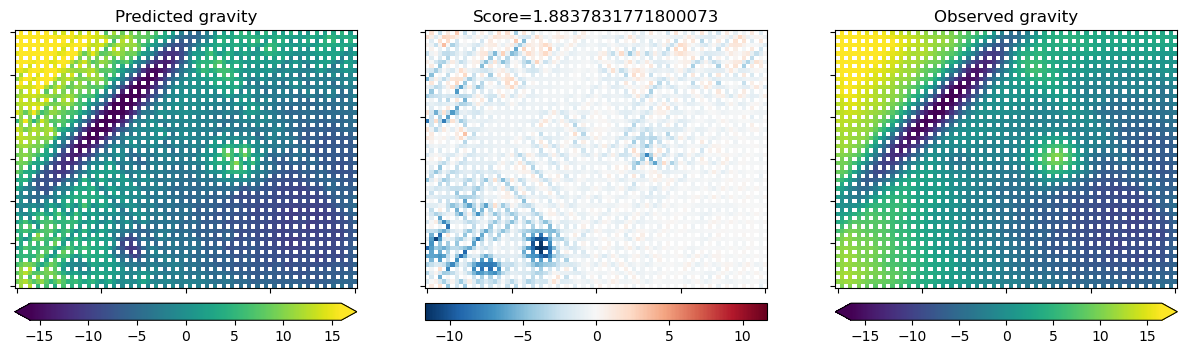

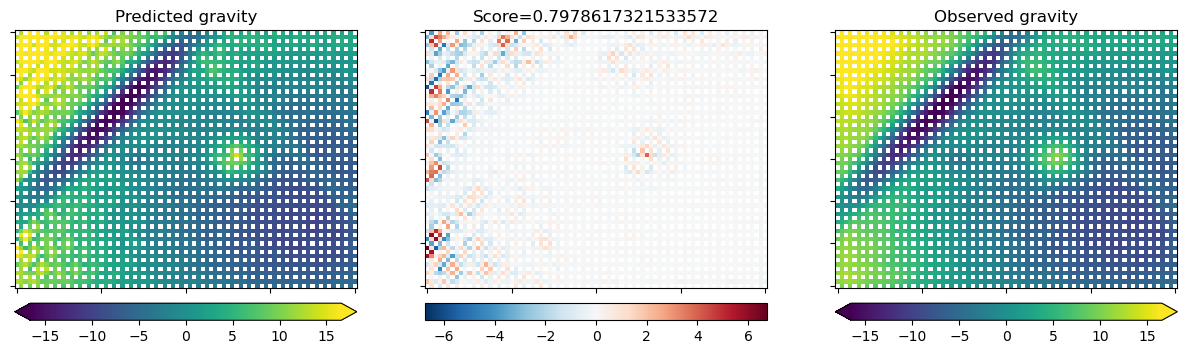

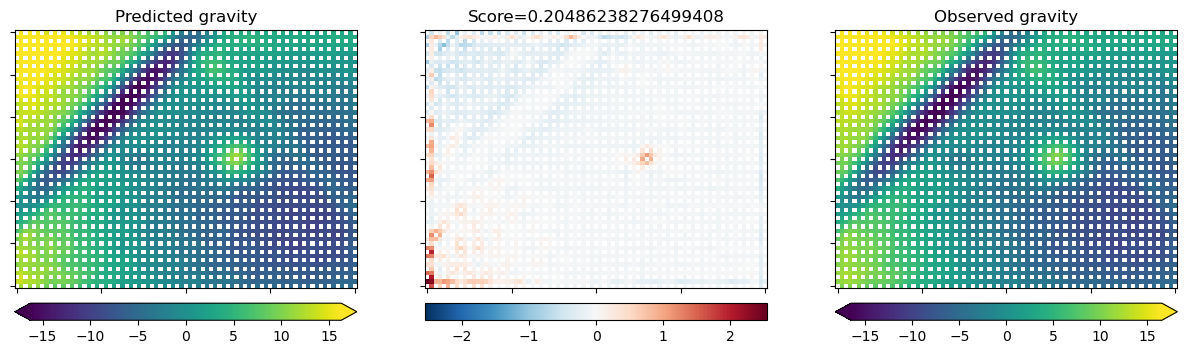

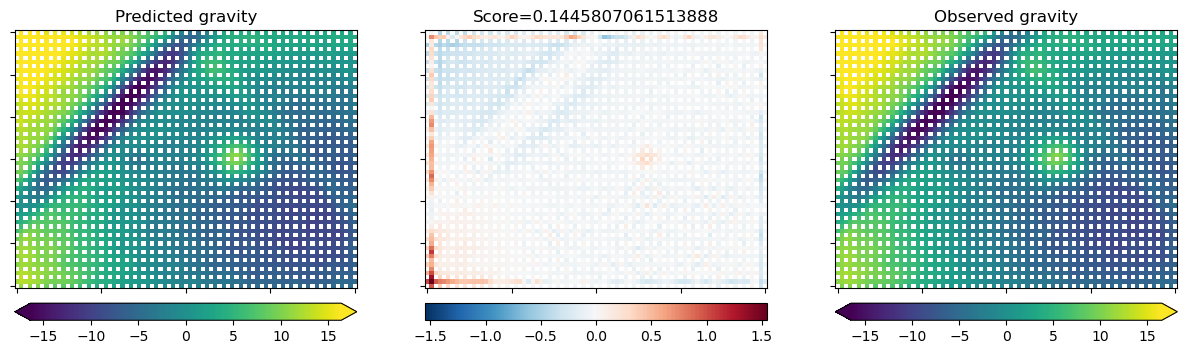

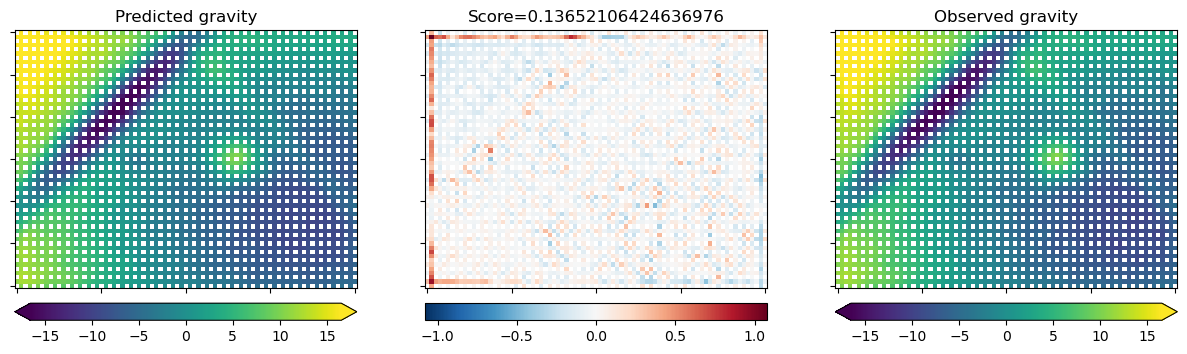

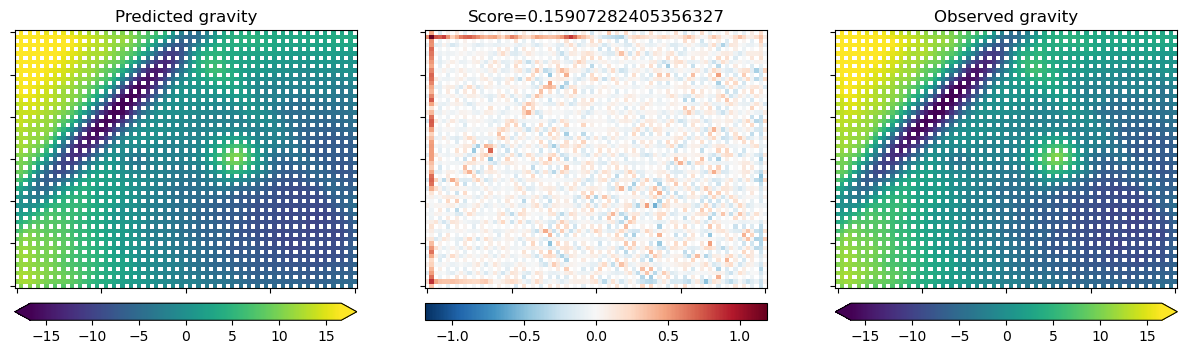

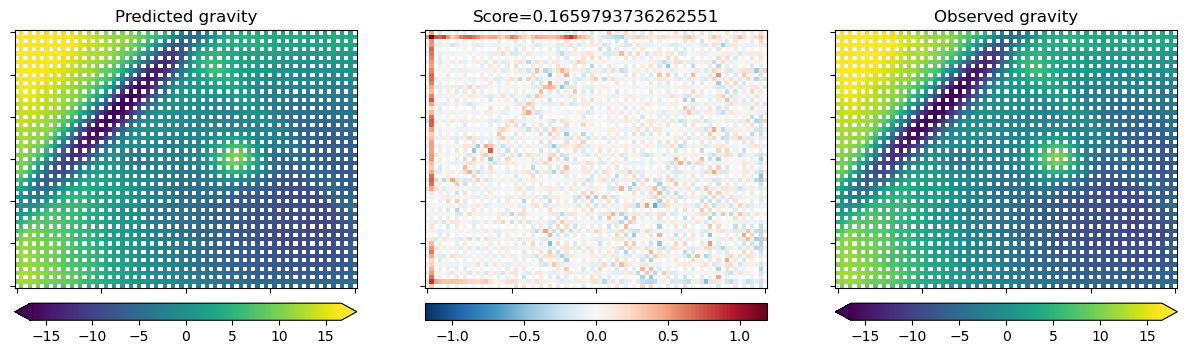

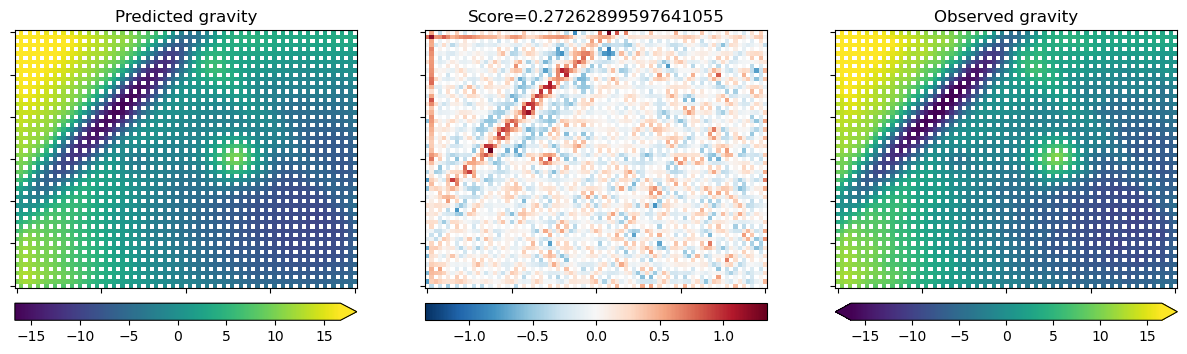

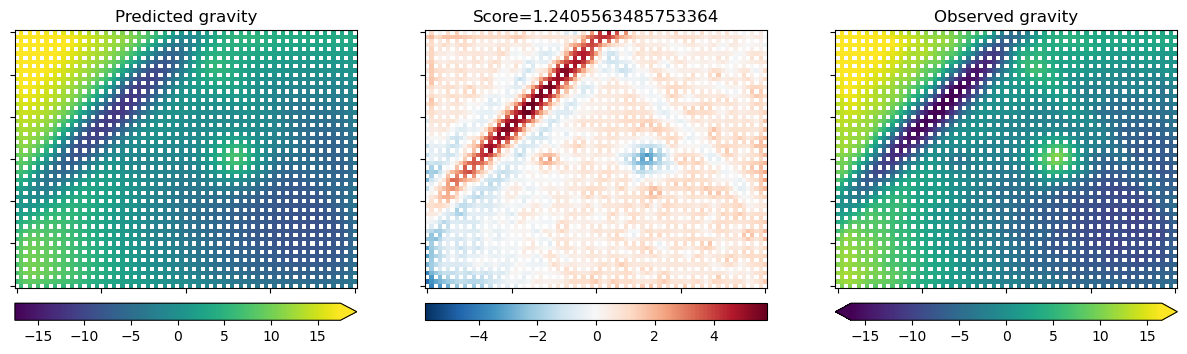

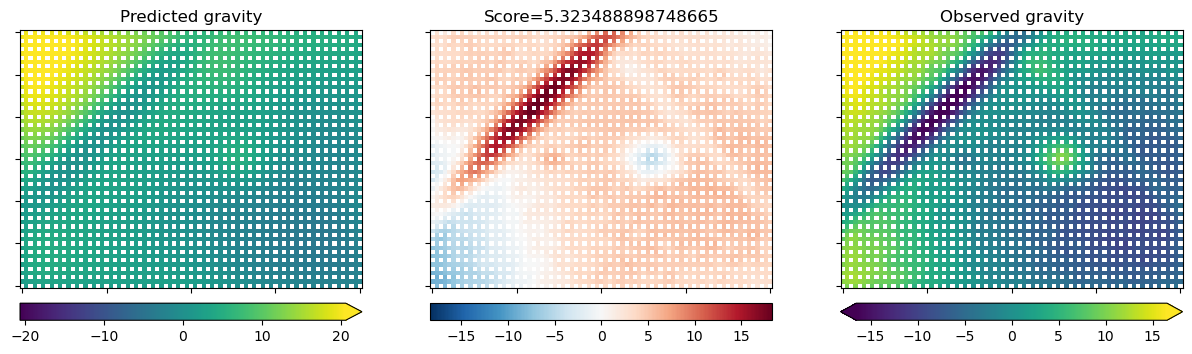

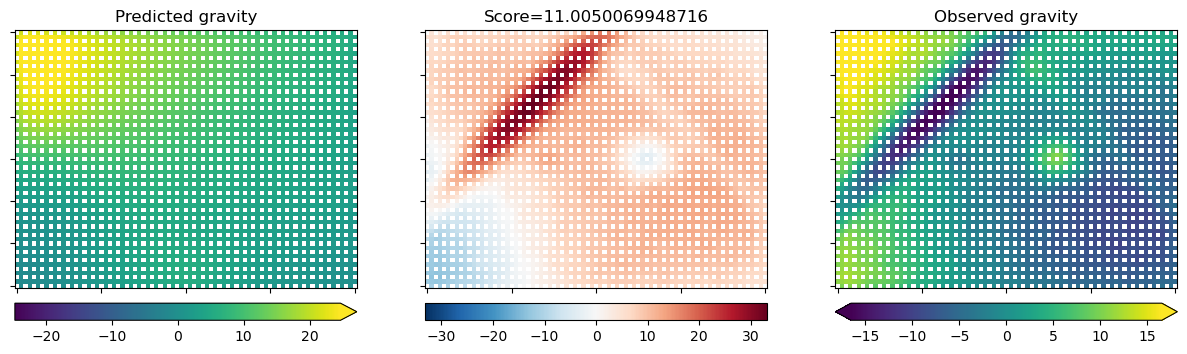

In [57]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set kwargs to pass to the inversion
kwargs = {
    "input_grav_column": "observed_grav",
    "prism_layer": starting_prisms,
    "deriv_type": "annulus",
    "zref": zref,
    "density_contrast": density_contrast,
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
}

# set which damping parameters to include
dampings = np.logspace(-3, 0, 12)

best_damping, _, _, scores = cross_validation.grav_optimal_parameter(
    training_data=grav_df_resampled[grav_df_resampled.test == False],  # noqa: E712
    testing_data=grav_df_resampled[grav_df_resampled.test == True],  # noqa: E712
    param_to_test=("solver_damping", dampings),
    progressbar=True,
    plot_grids=True,
    plot_cv=False,
    verbose=True,
    **kwargs,
)

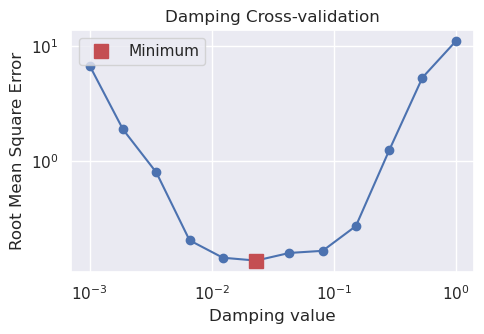

In [58]:
# Compare the scores and the damping values
plotting.plot_cv_scores(
    scores,
    dampings,
    param_name="Damping",
    logx=True,
    logy=True,
)

## 5) Cross validation for density and reference level

We will use the optimal damping value found in the previous step.

In [59]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set kwargs to pass to the inversion
kwargs = {
    "input_grav_column": "observed_grav",
    "deriv_type": "annulus",
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
}

# set which zref values to include
zrefs = np.linspace(400, 600, 8)

# set which density contrasts to include
density_contrasts = np.linspace(2200, 3000, 8)

# set the optimal damping value
kwargs["solver_damping"] = best_damping

# create all possible combinations of zref and density contrast
parameter_pairs = list(itertools.product(zrefs, density_contrasts))

# run inversions and collect scores
scores = []
for zref, density_contrast in parameter_pairs:
    # re-calculate density grid with new density contrast
    density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

    # create layer of prisms
    starting_prisms = utils.grids_to_prisms(
        starting_topography,
        zref,
        density=density,
    )

    # calculate forward gravity of starting prism layer
    # we don't need the training gravity data anymore, so we can use `grav_df` instead
    # of `grav_df_resampled`
    grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
        coordinates=(
            grav_df.easting,
            grav_df.northing,
            grav_df.upward,
        ),
        field="g_z",
        progressbar=False,
    )

    # calculate misfit as observed - starting
    grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

    # set regional misfit to 0
    grav_df["reg"] = 0

    # set the residual misfit to the full misfit
    grav_df["res"] = grav_df.misfit

    # update zref value in kwargs
    kwargs["zref"] = zref

    # update density contrast value in kwargs
    kwargs["density_contrast"] = density_contrast

    # update starting model in kwargs
    kwargs["prism_layer"] = starting_prisms

    # run cross validation
    score = cross_validation.constraints_cv_score(
        grav=grav_df,
        constraints=constraint_points,
        **kwargs,
    )
    scores.append(score)

# print parameter and score pairs
for (zref, density_contrast), score in zip(parameter_pairs, scores):
    print(
        f"Reference level: {zref}, Density contrast: {density_contrast} -> Score: ",
        score,
    )

best_idx = np.argmin(scores)
best_score = scores[best_idx]
best_zref = parameter_pairs[best_idx][0]
best_density = parameter_pairs[best_idx][1]
print(
    f"Best score of {best_score} with reference level={best_zref} and density contrast",
    best_density,
)

Reference level: 400.0, Density contrast: 2200.0 -> Score:  98.01066763450896
Reference level: 400.0, Density contrast: 2314.285714285714 -> Score:  97.34655736928218
Reference level: 400.0, Density contrast: 2428.5714285714284 -> Score:  96.90273746520421
Reference level: 400.0, Density contrast: 2542.857142857143 -> Score:  96.6291578264961
Reference level: 400.0, Density contrast: 2657.1428571428573 -> Score:  96.48671246483639
Reference level: 400.0, Density contrast: 2771.4285714285716 -> Score:  96.44505214450066
Reference level: 400.0, Density contrast: 2885.714285714286 -> Score:  96.48052769038479
Reference level: 400.0, Density contrast: 3000.0 -> Score:  96.57493594544228
Reference level: 428.57142857142856, Density contrast: 2200.0 -> Score:  70.4060372012958
Reference level: 428.57142857142856, Density contrast: 2314.285714285714 -> Score:  69.44350703605626
Reference level: 428.57142857142856, Density contrast: 2428.5714285714284 -> Score:  68.7784661647109
Reference leve

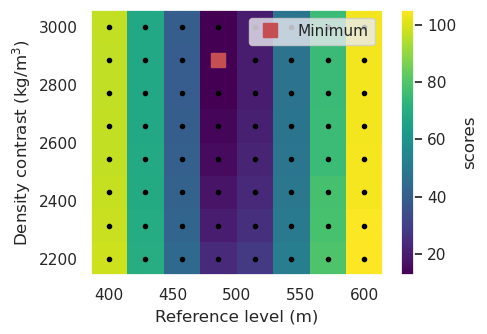

In [60]:
# Compare the scores and the damping values
plotting.plot_2_parameter_cv_scores(
    scores,
    parameter_pairs,
    param_names=("Reference level (m)", "Density contrast (kg/m$^3$)"),
    # logx=True,
    # logy=True,
    cmap="viridis",
)

## 6) Weighting grid
To force the invesion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

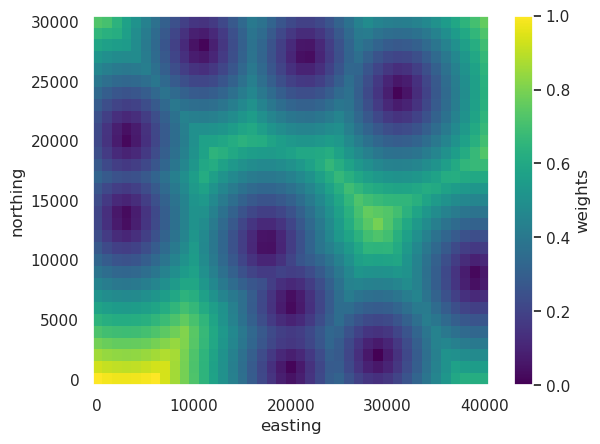

In [61]:
# recreate starting prism model with optimal zref and density contrast
zref = best_zref
density_contrast = best_density
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
min_dist = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
starting_prisms["weights"] = min_dist
starting_prisms.weights.plot()

### re-calculate the starting misfit with the new starting prism model

In [62]:
# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=False,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

## Perform inversion
Now we can perform the inversion, supplied the argument `weights_after_solving=True` and ensuring that the weighting grid is included as the `weights` variable to the argument `prism_layer`. Note that we have increased the `max_iterations` from 10 to 20. This is because the weighting grid reduces the correction values at each iterations, resulting in the need for more iterations.

INFO:root:starting inversion
INFO:root:extracted prism spacing is 1000.0
INFO:root:
 #################################### 
 iteration 1
INFO:root:Layer correction median: -14.9965 m, RMSE:88.4132 m
INFO:root:updated misfit RMSE: 3.2286
INFO:root:updated L2-norm: 1.7968, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.5104, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 2.5432 m, RMSE:39.9323 m
INFO:root:updated misfit RMSE: 1.9374
INFO:root:updated L2-norm: 1.3919, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2909, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 3.1623 m, RMSE:24.7704 m
INFO:root:updated misfit RMSE: 1.3062
INFO:root:updated L2-norm: 1.1429, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2179, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 1.2759 m, RMSE:17

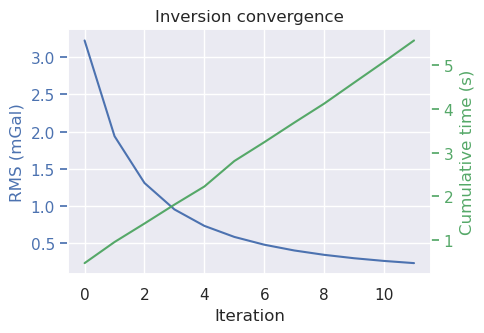

In [63]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    input_grav_column="observed_grav",
    prism_layer=starting_prisms,
    zref=zref,
    density_contrast=density_contrast,
    # display the convergence of the inversion
    plot_convergence=True,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="annulus",
    solver_damping=best_damping,
    # set stopping criteria
    max_iterations=60,
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.005,
    # enable the use of weights
    weights_after_solving=True,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

returning original grid
returning original grid


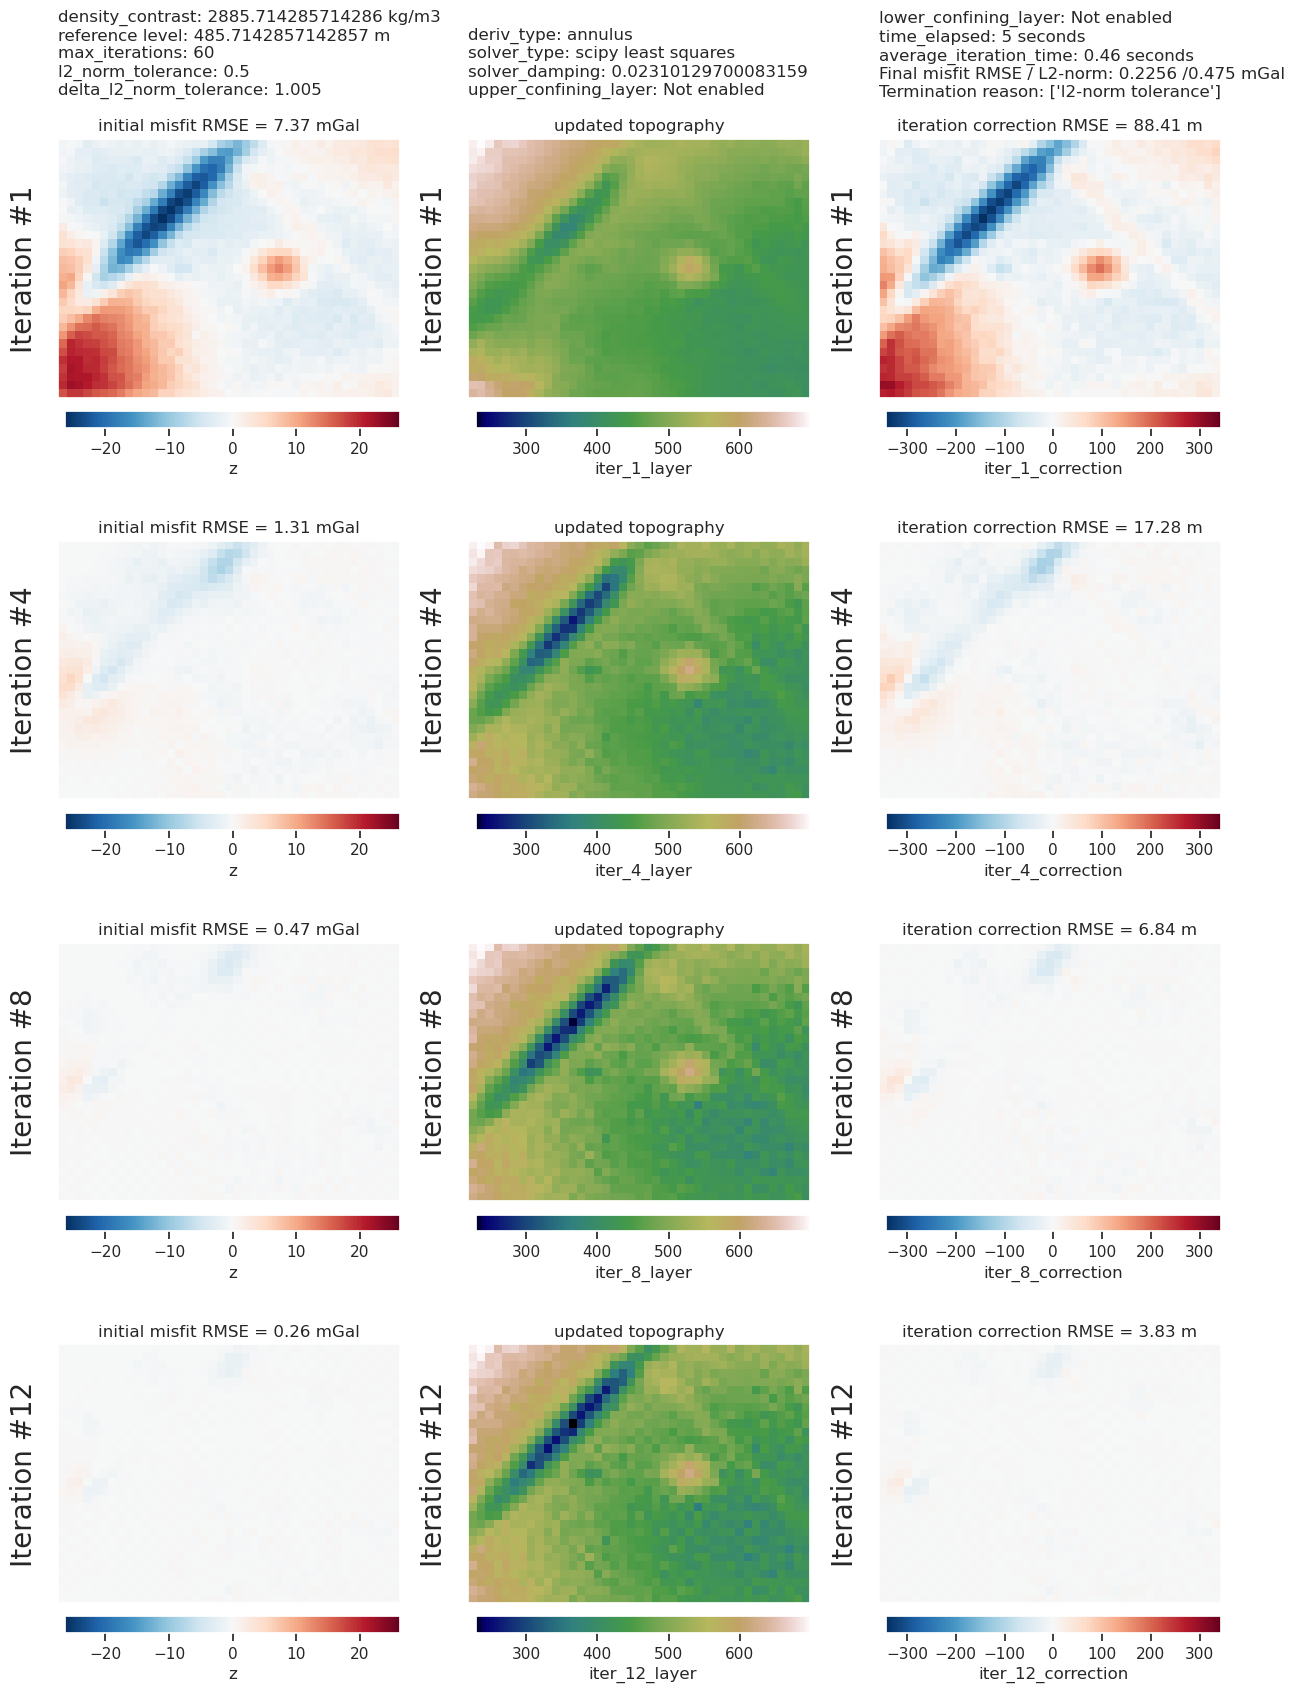

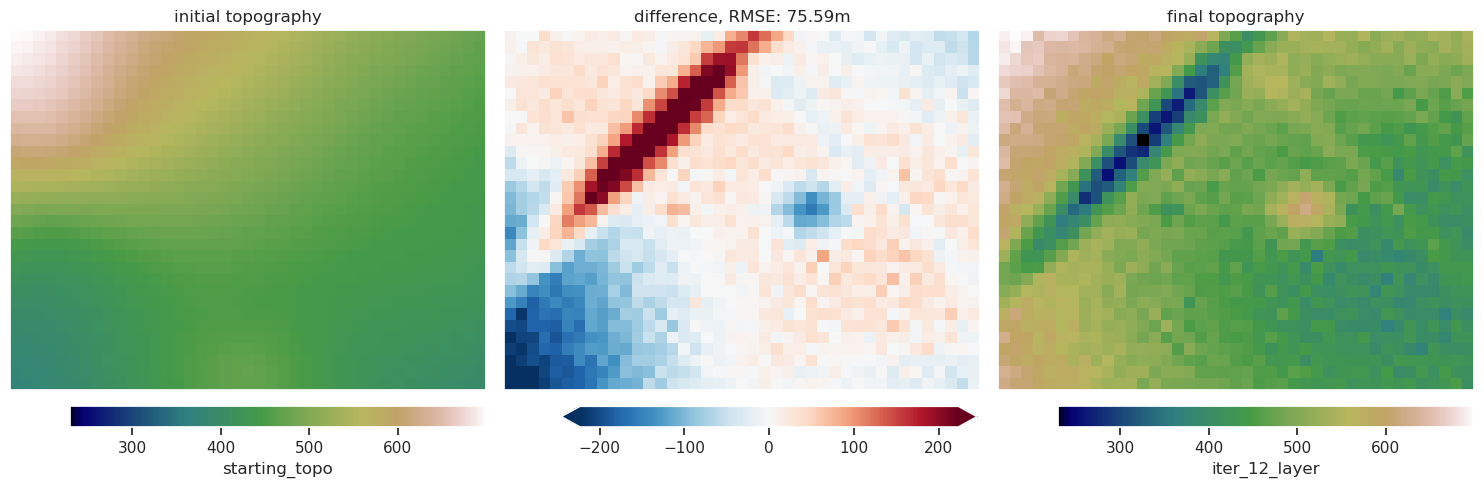

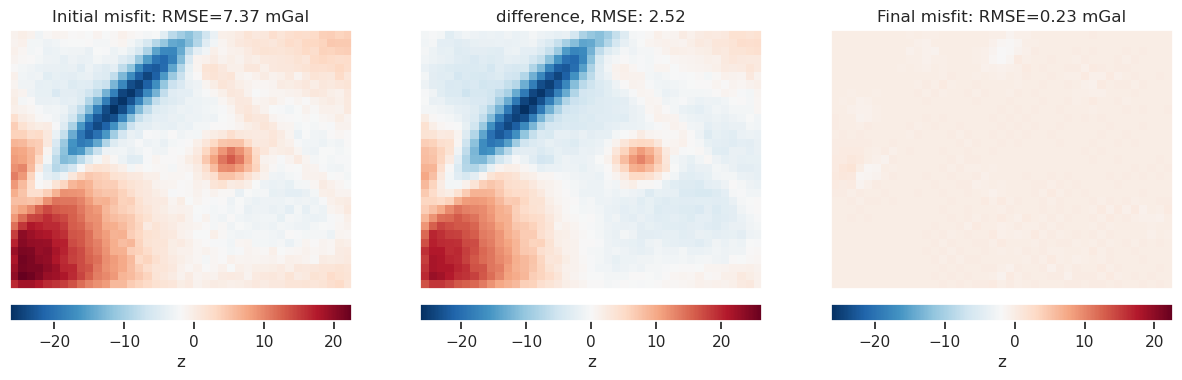

In [64]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    spacing,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

returning original grid
returning original grid


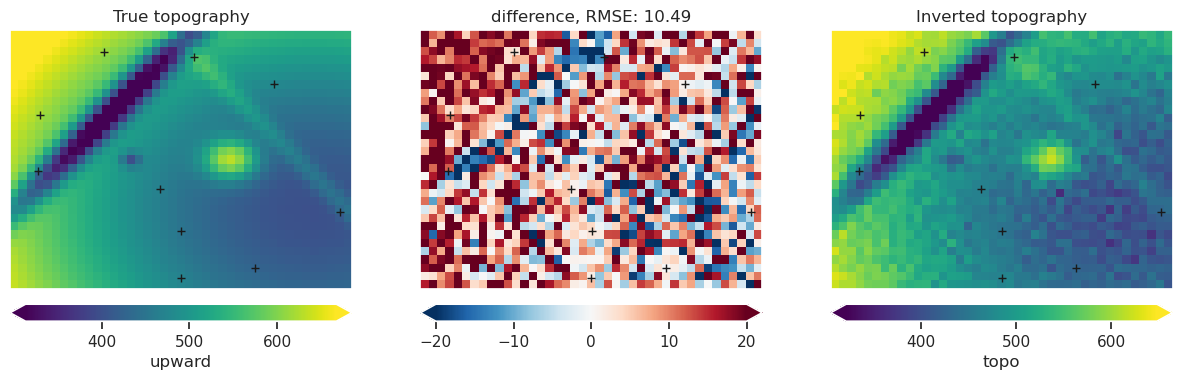

In [65]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = ap_utils.grd_compare(
    true_topography,
    final_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

As we can see by the low error values surround the constraints (black crosses), include the weighting grid has help the inversion adhere to the constraints. We can sample the inverted topography at the constraints and compare with the constraints true values.

In [66]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 2.99 m


#